# Friends 감정분석 with CNN
참고 소스 출처(링크) : 텐서플로2와 머신러닝으로 시작하는 자연어 처리(전창욱 외, 위키북스, 2020)

# 준비
라이브러리, 파라미터 세팅

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
#from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
import re
import json

from nltk.corpus import stopwords
from konlpy.tag import Okt

In [2]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'

BATCH_SIZE = 512
NUM_EPOCHS = 20
TEST_SIZE = 0.2
RANDOM_SEED = 42

model_name = 'cnn_classifier_eng'

# tf.random.set_seed 함수를 이용해 시드를 고정하여 학습 관련 랜덤 변수에 대한 초기 상태를 유지
tf.random.set_seed(RANDOM_SEED)

모델을 구현할 때 가장 중요한 것은 내가 학습한 상황을 그대로 보존하는 것이다.<br>
아무리 모델이 좋은 성능을 내더라도 그 성능이 재현되지 않으면 모델 검증을 할 수 없다.<br>
랜덤 시드를 고정하는 것은 모델과 샘플링을 하는 모든 랜덤 변수의 상태를 고정하기 위한 것이다.<br>
tf.random.set_seed 함수를 이용해 랜덤 시드를 고정하면 학습을 하기 위한 랜덤 변수에 대한 초기 상태를 유지할 수 있다.

# 데이터 로드

In [3]:
def jsonToDf(file_name):
    with open(file_name, encoding = 'utf-8', mode = 'r') as file:
        json_array = json.load(file)
  
    result = pd.DataFrame.from_dict(json_array[0])

    is_first = True
    for array in json_array:
        if is_first:
            is_first = False
            continue
    
        temp_df = pd.DataFrame.from_dict(array)
        result = result.append(temp_df, ignore_index = True)

    return result

In [4]:
train_df = jsonToDf(DATA_IN_PATH+'friends_train.json')
train2_df = jsonToDf(DATA_IN_PATH+'friends_dev.json')  # 기존 friends_dev.json 데이터를 friends_train.json과 통합
dev_df = jsonToDf(DATA_IN_PATH+'friends_test.json')  # 원 테스트 데이터는 검증용으로 사용
test_df = pd.read_csv(DATA_IN_PATH+'en_data.csv')  # 테스트(캐글) 데이터

# train + dev 합치기
train_tmp = train2_df.copy()
train_df = train_df.append(train_tmp, ignore_index = True)

In [5]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)

(11739, 4)
(2764, 4)
(1623, 5)


In [6]:
train_df.head()

,speaker,utterance,emotion,annotation
0,Chandler,also I was the point person on my companys tr...,neutral,4100000
1,The Interviewer,You mustve had your hands full.,neutral,5000000
2,Chandler,That I did. That I did.,neutral,5000000
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000
4,Chandler,My duties? All right.,surprise,2000030


In [7]:
dev_df.head()

,speaker,utterance,emotion,annotation
0,Mark,Why do all youre coffee mugs have numbers on ...,surprise,2000030
1,Rachel,Oh. Thats so Monica can keep track. That way ...,non-neutral,2100011
2,Rachel,Y'know what?,neutral,3000020
3,Ross,It didnt.,neutral,5000000
4,Frank,"Okay, so what you used to have with Rachel, is...",joy,1300010


In [8]:
test_df.head()

,id,i_dialog,i_utterance,speaker,utterance
0,0,0,0,Phoebe,"Alright, whadyou do with him?"
1,1,0,1,Monica,Oh! You're awake!
2,2,0,2,Joey,Then you gotta come clean with Ma! This is not...
3,3,0,3,Mr. Tribbiani,"Yeah, but this is"
4,4,0,4,Joey,I don't wanna hear it! Now go to my room!


# 데이터 탐색(EDA)

(-0.5, 799.5, 599.5, -0.5)

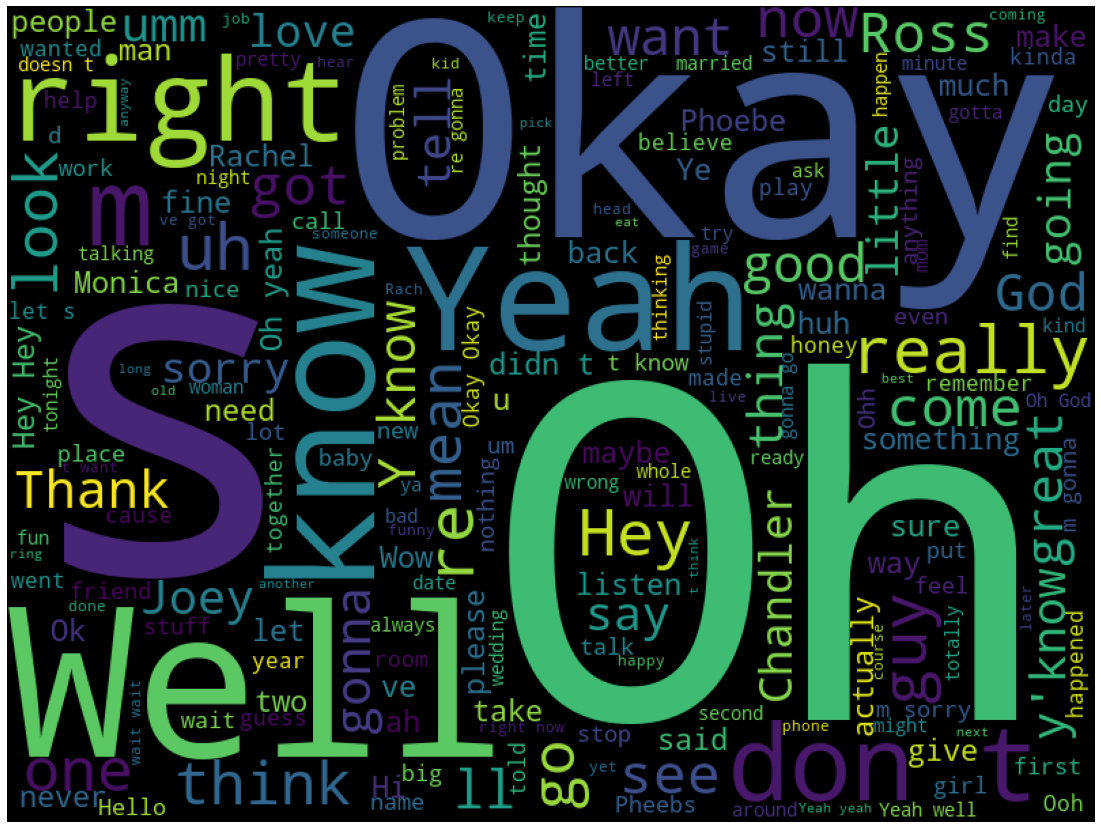

In [9]:
# 워드 클라우드 확인 (많이 사용된 단어)
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train_df['utterance']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

# 데이터 전처리

In [10]:
def data_cleansing(train_data, dev_data, test_data, con=0):  # 0: 전처리 없음(null값 공백 치환), 1: 숫자 제거, 2: 특수문자 제거
    global train_df
    global dev_df
    global test_df
    
    train_data = jsonToDf(DATA_IN_PATH+'friends_train.json')
    train2_df = jsonToDf(DATA_IN_PATH+'friends_dev.json')  # 기존 friends_dev.json 데이터를 friends_train.json과 통합
    dev_data = jsonToDf(DATA_IN_PATH+'friends_test.json')  # 원 테스트 데이터는 검증용으로 사용
    test_data = pd.read_csv(DATA_IN_PATH+'en_data.csv')  # 테스트(캐글) 데이터
    # train + dev 합치기
    train_tmp = train2_df.copy()
    train_data = train_data.append(train_tmp, ignore_index = True)
    
    train_df = train_data.copy()
    dev_df = dev_data.copy()
    test_df = test_data.copy()
    
    train_df.drop(['speaker','annotation'], axis=1, inplace=True)
    dev_df.drop(['speaker','annotation'], axis=1, inplace=True)
    test_df.drop(['i_dialog','i_utterance','speaker'], axis=1, inplace=True)
    
    if con == 1:  # 특수문자 제거 & Null 치환(공백), row 제거 없음
        # 정규 표현식을 이용해 숫자를 공백으로 변경(정규 표현식으로 \d는 숫자를 의미)
        train_df = train_df.fillna(' ')
        train_df['utterance'] = train_df['utterance'].str.replace("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\x92]","") # 정규 표현식 수행(특수문자 제거)
        dev_df = dev_df.fillna(' ')
        dev_df['utterance'] = dev_df['utterance'].str.replace("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\x92]","") # 정규 표현식 수행(특수문자 제거)
        test_df = test_df.fillna(' ')
        test_df['utterance'] = test_df['utterance'].str.replace("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\x92]","") # 정규 표현식 수행(특수문자 제거)
        
    elif con == 2:  # 영어 이외 제거 & Null 치환(공백), row 제거 없음
        train_df = train_df.fillna(' ')
        train_df['utterance'] = train_df['utterance'].str.replace("[^a-zA-Z]"," ") # 정규 표현식 수행(영어 이외 제거)
        dev_df = dev_df.fillna(' ')
        dev_df['utterance'] = dev_df['utterance'].str.replace("[^a-zA-Z]"," ") # 정규 표현식 수행(영어 이외 제거)
        test_df = test_df.fillna(' ')
        test_df['utterance'] = test_df['utterance'].str.replace("[^a-zA-Z]"," ") # 정규 표현식 수행(영어 이외 제거)
        
    else:
        train_df = train_df.fillna(' ')
        dev_df = dev_df.fillna(' ')
        test_df = test_df.fillna(' ')
    
    print('전처리 후 학습 데이터 :',train_df.shape)
    print('전처리 후 검증 데이터 :',dev_df.shape)
    print('전처리 후 테스트 데이터 :',test_df.shape)


In [11]:
# 데이터 전처리 선택
data_cleansing(train_df, dev_df, test_df, con=2)  # 0: 전처리 없음(null값 공백 치환), 1: 특수문자 제거, 2: 영어이외 제거

전처리 후 학습 데이터 : (11739, 2)
전처리 후 검증 데이터 : (2764, 2)
전처리 후 테스트 데이터 : (1623, 2)


In [12]:
clean_train_review = train_df['utterance']
clean_dev_review = dev_df['utterance']
clean_test_review = test_df['utterance']

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)

train_sequences = tokenizer.texts_to_sequences(clean_train_review)
dev_sequences = tokenizer.texts_to_sequences(clean_dev_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index # 단어 사전 형태
word_vocab["<PAD>"] = 0

In [14]:
print("전체 단어 개수: ", len(word_vocab))

전체 단어 개수:  5653


In [15]:
word_vocab

{'i': 1,
 'you': 2,
 's': 3,
 'the': 4,
 'it': 5,
 'to': 6,
 'a': 7,
 'that': 8,
 'and': 9,
 't': 10,
 'oh': 11,
 'what': 12,
 'no': 13,
 'know': 14,
 'm': 15,
 'we': 16,
 'is': 17,
 'this': 18,
 'me': 19,
 'okay': 20,
 'so': 21,
 'yeah': 22,
 'just': 23,
 'of': 24,
 'my': 25,
 'in': 26,
 're': 27,
 'hey': 28,
 'have': 29,
 'don': 30,
 'do': 31,
 'well': 32,
 'can': 33,
 'on': 34,
 'not': 35,
 'are': 36,
 'was': 37,
 'all': 38,
 'for': 39,
 'right': 40,
 'he': 41,
 'but': 42,
 'with': 43,
 'be': 44,
 'here': 45,
 'your': 46,
 'go': 47,
 'like': 48,
 'get': 49,
 'there': 50,
 'gonna': 51,
 'out': 52,
 'y': 53,
 'uh': 54,
 'really': 55,
 'about': 56,
 'she': 57,
 'how': 58,
 'think': 59,
 'up': 60,
 'look': 61,
 'll': 62,
 'one': 63,
 'they': 64,
 'if': 65,
 'now': 66,
 'her': 67,
 'got': 68,
 'at': 69,
 'mean': 70,
 'see': 71,
 'him': 72,
 'god': 73,
 've': 74,
 'ross': 75,
 'come': 76,
 'did': 77,
 'good': 78,
 'why': 79,
 'sorry': 80,
 'want': 81,
 'joey': 82,
 'tell': 83,
 'great': 8

In [16]:
train_word_counts = train_df['utterance'].apply(lambda x:len(x.split(' ')))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  after removing the cwd from sys.path.


Text(0, 0.5, 'Number of reviews')

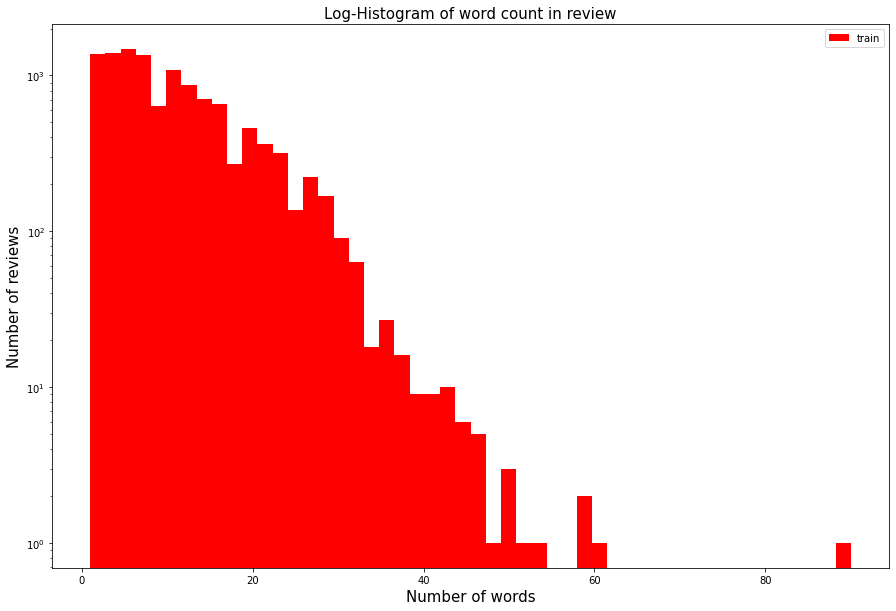

In [17]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)

In [18]:
print('발화 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('발화 단어 개수 최소 값: {}'.format(np.min(train_word_counts)))
print('발화 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('발화 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('발화 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('발화 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('발화 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))

발화 단어 개수 최대 값: 90
발화 단어 개수 최소 값: 1
발화 단어 개수 평균 값: 10.82
발화 단어 개수 표준편차: 7.79
발화 단어 개수 중간 값: 9.0
발화 단어 개수 제 1 사분위: 5.0
발화 단어 개수 제 3 사분위: 15.0


In [19]:
MAX_SEQUENCE_LENGTH = 9  # 단어 개수 통계 중간값을 패딩 처리 최대 길이로 정한 것

train_data_array = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # 학습 데이터를 벡터화
dev_data_array = pad_sequences(dev_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # 검증 데이터를 벡터화
test_data_array = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # 검증 데이터를 벡터화

In [20]:
# Friends 감정 딕셔너리 생성
emoset = {'non-neutral': 0,
          'neutral': 1, 
          'joy': 2,
          'sadness': 3,
          'fear': 4,
          'anger': 5,
          'surprise': 6,
          'disgust': 7}

In [21]:
# 'label' 컬럼 신규
#for emo in train_df['emotion'][:10]:  print(emo, emoset[emo])
train_df['label'] = [emoset[emo] for emo in train_df['emotion']]
dev_df['label'] = [emoset[emo] for emo in dev_df['emotion']]

In [22]:
# 학습, 검증(Origianl Testset) 데이터 레이블 넘파이 배열 처리
y_train = np.array(train_df['label'])
y_dev = np.array(dev_df['label'])

# 모델 생성

### 파라미터 정의
모델에 필요한 하이퍼파라미터를 정의한다. 각 모델 레이어 차원 수나 드롭아웃을 정하는 하이퍼파라미터 명칭은 key에, 키에 해당하는 하이퍼파라미터 명칭에 대한 값은 value에 입력한다.

모델에 필요한 하이퍼파라미터 값으로 에폭 수, 배치 크기, 단어 사전의 크기, 임베딩 크기를 지정한다. 단어 사전의 크기는 데이터 정보를 담은 딕셔너리에서 받아오고, 임베딩 크기는 128로 설정한다.

In [23]:
MAX_LEN = train_data_array.shape[1]

kargs = {'model_name': model_name,
         'vocab_size': len(word_vocab),
         'embedding_size': 128,
         'num_filters': 100,
         'dropout_rate': 0.5,  # 0.5
         'hidden_dimension': 300,  # 250
         'output_dimension':8}

학습 데이터와 모델 하이퍼파라미터가 준비됐으니 모델을 구현해 본다.<br>
모델은 tensorflow.keras 기반으로 클래스로 모델을 정의해서 구현한다.<br>
본 케이스는 합성곱 신경망 모델을 사용한다.

In [24]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.softmax,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

클래스로 모델을 구현하려면 tf.keras.Model을 상속받아야 한다.<br>
tf.keras.Model을 상속받기 위해 'class CNNClassifier(tf.keras.Model):'으로 구현을 시작한다.<br>
가장 먼저 구현할 함수는 &#95;&#95;init&#95;&#95; 함수이다. 이 함수는 CNNClassifier 모델 객체를 생성할 때마다 실행된다.<br>
&#95;&#95;init&#95;&#95; 함수는 매개변수로 모델 레이어의 입력 및 출력 차원 수를 정의하는 하이퍼파라미터 정보를 dict 객체로 받는다.<br>

&#95;&#95;init&#95;&#95; 함수 구현을 시작하면 먼저 super 함수를 확인할 수 있다.<br>
tf.keras.Model 클래스를 상속받는 경우 super 함수를 통해 부모 클래스에 있는 &#95;&#95;init&#95;&#95; 함수를 호출해야 한다.<br>
super 함수를 통해 부모 클래스 &#95;&#95;init&#95;&#95; 함수 인자에 모델 이름을 전달하면<br>
tf.keras.Model을 상속받은 모든 자식은 해당 모델의 이름을 공통적으로 사용한다.<br>

그다음으로 텍스트 워드 임베딩 벡터를 위해 layers.Embedding 객체를 생성한다.<br>
이때 입력 파라미터로 데이터 사전 수와 단어 임베딩 차원 수를 입력한다.<br>

본 CNN 레이어는 Yoon Kim의 CNN과 유사하게 구현되어 있다. ("Convolutional Neural Network for Sentence Classification" 논문)<br>
임베딩 벡터를 생성한 후, 케라스의 Conv1D를 활용해 총 3개의 합성곱 레이어를 사용하고 각각 필터의 크기를 다르게 해서 값을 추출한다.<br>
self.conv_list로 관련 함수를 저장하며 kernel_size의 입력에 리스트 컴프리헨션 형태로 구현하면<br>
kernel_size가 3,4,5인 Conv1D 객체 리스트로 구현된다.<br>
합성곱 신경망 이후에 맥스 풀링 레이어를 적용한다. 즉, 해당 모델은 총 3개의 합성곱 + 맥스 풀링 레이어를 사용하는 구조이다.<br>

마지막에는 과적합을 방지하기 위한 Dropout과 완전 연결 계층인 2개 층을 쌓아<br>
최종 출력 차원인 kargs['output_dimension']출력을 맞춰 모델을 구성한다.<br>

Dropout은 tf.keras.layers.Dropout을 활용해 생성한다.<br>
이 때 파라미터 값은 Dropout을 적용할 비율값이다.

완전 연결 계층은 tf.keras.layers.Dense를 통해 객체를 생성해 구성한다.<br>
객체를 생성할 때 입력 파라미터로 네트워크를 출력할 때 나오는 벡터 차원 수 units와 네트워크에서 사용할 활성화 함수를 지정한다.<br>
활성화 함수로 relu 함수를 사용하고, tf.keras.activations.relu 함수를 activation 파라미터에 입력하면 된다.<br>

이제 피드 포워드 네트워크를 거쳐 나온 벡터를 가지고 회귀(regression)를 할 수 있도록 만들어야 한다.<br>
앞서 사용한 Dense가 위의 네트워크를 거쳐 나온 벡터에서 회귀하게 할 수 있다.<br>
앞선 방식처럼 Dense 객체를 생성하고 units에는 1을 입력하고 activation에는 tf.keras.activations.sigmoid를 지정한다.<br>
이렇게 구현하면 Dense 레이어를 통해 예측한 값을 0~1의 값으로 표현할 수 있게 된다.<br>

 &#95;&#95;init&#95;&#95; 함수를 통해 생성한 레이어들을 call 함수를 통해 실행할 수 있다.<br>
 여기서 이전에 구성한 리스트 컴프리헨션 형태의 Conv1D 리스트 값을 각각 다른 필터의 값이 Conv1D를 통해<br>
 문장의 각기 다른 표현값들을 추출해서 concat을 통해 출력값들을 합친다.<br>
 이후 완전 연결 계층(fc)을 통해 분류 모델을 만들기 위한 학습 모델 구조를 완성한다.<br>
 즉 &#95;&#95;init&#95;&#95;을 통해 생성한 레이어들을 call 함수를 통해 실행할 수 있고,<br>
 최종적으로 모든 레이어를 통과한 후에 마지막에 예측 값을 출력하는 구조다.

# 모델 학습

RNN이 단어의 입력 순서를 중요하게 반영한다면, CNN은 문장의 지역 정보를 보존하면서 각 문장 성분의 등장 정보를 학습에 반영하는 구조로 풀어간다.<br>
학습할 때 각 필터 크기를 조절하면서 언어의 특징 값을 추출하게 되는데, 기존의 N-gram(2그램,3그램) 방식과 유사하다고 볼 수 있다.<br>

예를 들어 "나는 배가 고프다"라는 문장을 2그램을 사용한다면 "나 는 / 는 배 / 배 가 / 가 고프 / 고프 다/"로 각각 문장 성분을 쪼개서 활용하는 접근법, 단어의 각 벡터 값을 투영해서 컨볼루션 필터값에 적용하는 원리다.

In [25]:
model = CNNClassifier(**kargs)

# 학습 프로세스 설정 (sparse_categorical_crossentropy 기반)
from keras import optimizers
model.compile(
            optimizer=optimizers.RMSprop(lr=0.001),
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])

# optimizer='sgd'
# optimizer='rmsprop'
# optimizer='adam'
# optimizer=optimizers.RMSprop(lr=0.001)

검증 정확도를 통한 EarlyStopping 기능과 모델 저장 방식을 지정하고,<br>
모델을 검증하기 위한 검증 데이터도 model.fit 안에 있는 validation_split로 지정한 다음 학습을 시작한다.

In [26]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.0001, patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights_cnn_friends.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/cnn_classifier_eng -- Folder already exists 



In [27]:
history = model.fit(train_data_array, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=TEST_SIZE, callbacks=[earlystop_callback, cp_callback])

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 1.6373 - sparse_categorical_accuracy: 0.4288
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.43058, saving model to ./data_out/cnn_classifier_eng/weights_cnn_friends.h5
19/19 [==============================] - 1s 35ms/step - loss: 1.6373 - sparse_categorical_accuracy: 0.4288 - val_loss: 1.6435 - val_sparse_categorical_accuracy: 0.4306
Epoch 2/20
18/19 [===========================>..] - ETA: 0s - loss: 1.5575 - sparse_categorical_accuracy: 0.4502
Epoch 00002: val_sparse_categorical_accuracy improved from 0.43058 to 0.43313, saving model to ./data_out/cnn_classifier_eng/weights_cnn_friends.h5
19/19 [==============================] - 0s 11ms/step - loss: 1.5556 - sparse_categorical_accuracy: 0.4506 - val_loss: 1.6136 - val_sparse_categorical_accuracy: 0.4331
Epoch 3/20
16/19 [========================>.....] - ETA: 0s - loss: 1.5073 - sparse_categorical_accuracy: 0.4601
Epoch 00003: val_sparse_categori

In [28]:
train_preds = model.predict(train_data_array)

preds = []
for i, pred in enumerate(train_preds):
    result = np.argmax(pred)
    preds.append(result)

In [29]:
from sklearn.metrics import f1_score
f1 = f1_score(y_train, preds, average='weighted')
print('F1 Score : {:.4f}'.format(f1))

F1 Score : 0.5277


In [30]:
from sklearn.metrics import classification_report

target_names = ['non-neutral','neutral','joy','sadness','fear','anger','surprise','disgust']

print(classification_report(y_train, preds, target_names=target_names))

              precision    recall  f1-score   support

 non-neutral       0.39      0.51      0.44      2231
     neutral       0.70      0.73      0.71      5243
         joy       0.56      0.47      0.51      1406
     sadness       0.64      0.03      0.06       413
        fear       0.00      0.00      0.00       214
       anger       0.00      0.00      0.00       598
    surprise       0.44      0.70      0.54      1371
     disgust       0.00      0.00      0.00       263

    accuracy                           0.56     11739
   macro avg       0.34      0.30      0.28     11739
weighted avg       0.53      0.56      0.53     11739



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# Loss, Accuracy 시각화 함수 1
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

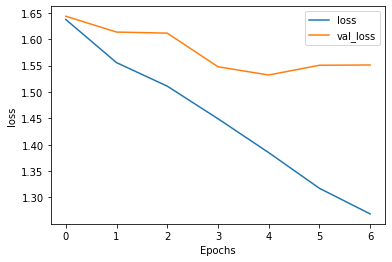

In [32]:
plot_graphs(history, 'loss')

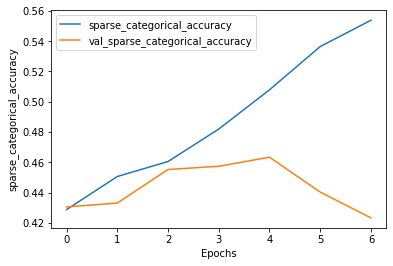

In [33]:
plot_graphs(history, 'sparse_categorical_accuracy')

In [34]:
# Loss, Accuracy 시각화 함수 2
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

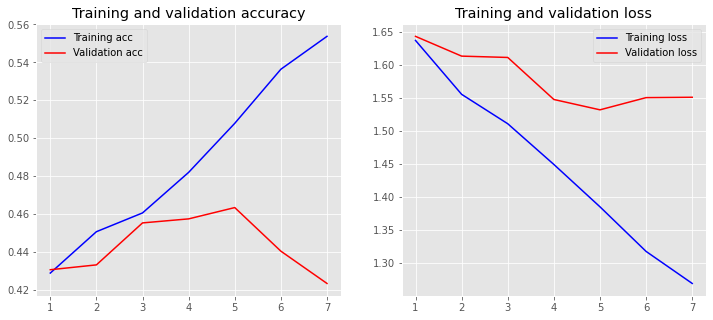

In [35]:
plot_history(history)

# 모델 평가 - 검증 데이터셋(Original Test Dataset)

테스트 데이터에 감정에 대한 라벨 값이 있는 경우이므로, 바로 결과를 확인할 수 있다.<br>
테스트 데이터를 불러올 때 학습 데이터를 전처리하는 과정과 동일하게 진행한 후 넘파이 파일로 저장한 데이터를 불러오면 된다.

In [36]:
SAVE_FILE_NM = 'weights_cnn_friends.h5' #저장된 best model 이름
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [37]:
results = model.evaluate(dev_data_array, y_dev)

87/87 [==============================] - 0s 2ms/step - loss: 1.4725 - sparse_categorical_accuracy: 0.4830


In [38]:
# optimizer='sgd' => loss: 1.97499680519104, acc: 0.4659913182258606
# optimizer='rmsprop' => loss: 1.4988404512405396, acc: 0.4768451452255249
# optimizer=optimizers.RMSprop(lr=0.001) => loss: 1.5147888660430908, acc: 0.47286540269851685
# optimizer='adam' => loss: 1.4809116125106812, acc: 0.4688856601715088
results

[1.4724936485290527, 0.4829956591129303]

In [39]:
dev_preds = model.predict(dev_data_array)

preds = []
for i, pred in enumerate(dev_preds):
    result = np.argmax(pred)
    preds.append(result)

In [40]:
from sklearn.metrics import f1_score
f1 = f1_score(y_dev, preds, average='weighted')
print('F1 Score : {:.5f}'.format(f1))

F1 Score : 0.42258


In [41]:
from sklearn.metrics import classification_report

target_names = ['non-neutral','neutral','joy','sadness','fear','anger','surprise','disgust']

print(classification_report(y_dev, preds, target_names=target_names))

              precision    recall  f1-score   support

 non-neutral       0.28      0.18      0.22       541
     neutral       0.54      0.80      0.64      1287
         joy       0.41      0.28      0.33       304
     sadness       0.00      0.00      0.00        85
        fear       0.00      0.00      0.00        32
       anger       0.00      0.00      0.00       161
    surprise       0.42      0.45      0.43       286
     disgust       0.00      0.00      0.00        68

    accuracy                           0.48      2764
   macro avg       0.21      0.21      0.20      2764
weighted avg       0.39      0.48      0.42      2764



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# (참고) 제출 파일 생성

In [42]:
start = time.time()

preds = model.predict(test_data_array)

test_preds = []
for i, pred in enumerate(preds):
    result = np.argmax(pred)
    test_preds.append(result)
    print(str(i)+"번 인덱스 데이터 처리 완료 =>", pred, test_preds[i])

print("time : ", time.time() - start)

0번 인덱스 데이터 처리 완료 => [0.09960504 0.6317319  0.09164292 0.01369881 0.0116747  0.03225226
 0.10345355 0.01594078] 1
1번 인덱스 데이터 처리 완료 => [0.16088733 0.19426967 0.13558689 0.02348427 0.02528137 0.05652679
 0.37439075 0.02957296] 6
2번 인덱스 데이터 처리 완료 => [0.24742368 0.26225424 0.07462346 0.04176155 0.03903178 0.08547948
 0.20420022 0.04522557] 1
3번 인덱스 데이터 처리 완료 => [0.10728412 0.66457903 0.06866763 0.01219588 0.01124967 0.03243568
 0.08984691 0.01374106] 1
4번 인덱스 데이터 처리 완료 => [0.2197119  0.32588676 0.17862706 0.07045579 0.04037437 0.08691684
 0.04442778 0.0335995 ] 1
5번 인덱스 데이터 처리 완료 => [0.16197018 0.49027228 0.12274433 0.03456692 0.02600908 0.06220523
 0.07688795 0.02534409] 1
6번 인덱스 데이터 처리 완료 => [0.17754625 0.433419   0.15506823 0.03699673 0.02528529 0.05819129
 0.08433806 0.02915513] 1
7번 인덱스 데이터 처리 완료 => [0.23424684 0.21562396 0.13420227 0.05544385 0.04501622 0.08526094
 0.19094792 0.03925809] 0
8번 인덱스 데이터 처리 완료 => [0.16902104 0.4203974  0.07511883 0.01858984 0.01911816 0.05621942
 0.217311

 0.02584505 0.03724878] 1
544번 인덱스 데이터 처리 완료 => [0.10682458 0.61541826 0.17139874 0.03394869 0.01347861 0.02991868
 0.01635649 0.01265601] 1
545번 인덱스 데이터 처리 완료 => [0.10835378 0.53829306 0.1541071  0.01820605 0.01568595 0.04375351
 0.10115518 0.02044537] 1
546번 인덱스 데이터 처리 완료 => [0.2943104  0.21180128 0.13408867 0.07683665 0.04426889 0.075091
 0.12664612 0.03695695] 0
547번 인덱스 데이터 처리 완료 => [0.17652108 0.345289   0.28656211 0.03192355 0.01923467 0.04573615
 0.07008068 0.02465277] 1
548번 인덱스 데이터 처리 완료 => [0.18433878 0.50173074 0.15041319 0.02918211 0.02034848 0.05101778
 0.04143096 0.02153796] 1
549번 인덱스 데이터 처리 완료 => [0.13352247 0.53921396 0.17996259 0.01676578 0.01068426 0.03365667
 0.07293263 0.01326164] 1
550번 인덱스 데이터 처리 완료 => [0.2534781  0.29182157 0.15583675 0.07741638 0.04537402 0.08465709
 0.04869271 0.04272341] 1
551번 인덱스 데이터 처리 완료 => [0.238782   0.27050522 0.15152931 0.03419911 0.02847099 0.05932069
 0.18452163 0.03267106] 1
552번 인덱스 데이터 처리 완료 => [0.1486026  0.48282766 0.22086853 

 0.06866726 0.03679051] 0
1090번 인덱스 데이터 처리 완료 => [0.11569196 0.60846925 0.13661274 0.0258009  0.01677918 0.04046979
 0.03740222 0.01877404] 1
1091번 인덱스 데이터 처리 완료 => [0.13027996 0.38538423 0.25120783 0.03428791 0.02355564 0.0582785
 0.08859327 0.02841271] 1
1092번 인덱스 데이터 처리 완료 => [0.35819414 0.08872955 0.12121155 0.09529547 0.06440051 0.09255056
 0.12973773 0.04988046] 0
1093번 인덱스 데이터 처리 완료 => [0.15870804 0.35239825 0.26553327 0.04346136 0.02614392 0.05890128
 0.06607807 0.02877582] 1
1094번 인덱스 데이터 처리 완료 => [0.13763724 0.36123955 0.21837437 0.03361089 0.02681206 0.06391868
 0.12590285 0.03250443] 1
1095번 인덱스 데이터 처리 완료 => [0.29617497 0.22300874 0.05778063 0.03955275 0.04640191 0.09679924
 0.1955198  0.04476189] 0
1096번 인덱스 데이터 처리 완료 => [0.16768578 0.53739715 0.115389   0.02482015 0.01676583 0.04807348
 0.07171806 0.01815053] 1
1097번 인덱스 데이터 처리 완료 => [0.06135079 0.75423646 0.1109544  0.01047425 0.00733559 0.02155301
 0.02489285 0.00920265] 1
1098번 인덱스 데이터 처리 완료 => [0.20845538 0.23102859 0

In [43]:
# 감정 레이블링 위해 기존 정수형 레이블로부터 역변환
emoset_reverse = dict(zip(emoset.values(),emoset.keys()))

# 테스트 데이터의 id, 리뷰 부분을 리스트 처리
ids = list(test_df['id'])
test_utterances = list(test_df['utterance'])

# 숫자로 인코딩 된 레이블을 감정명으로 재매칭
emo_preds = [emoset_reverse[label] for label in test_preds]

# 판다스 데이터프레임 통해 데이터 구성하여 output에 투입
output = pd.DataFrame( data={"Id": ids, "Predicted": emo_preds} )
output.head()

,Id,Predicted
0,0,neutral
1,1,surprise
2,2,neutral
3,3,neutral
4,4,neutral


In [44]:
# 해당 경로가 없으면 생성
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

# csv파일로 만든다
output.to_csv(DATA_OUT_PATH + "FRIENDS_CNN.csv", index = False)  # 앙상블 조합 및 캐글 용도

### 캐글 제출 결과
**[2020.12.18]**<br>
0.44759<br>

**[2020.12.18]**<br>
0.45745

# (참고) 입력 문장 감정/확률 예측하기
문자열의 결과를 예측하는 함수를 만들어 본다.

In [40]:
sentences = ['how do you know?', 'I love you!', 'I hate that!']

In [41]:
# 감정 레이블링 위해 기존 정수형 레이블로부터 역변환
emoset_reverse = dict(zip(emoset.values(),emoset.keys()))

sentence_sequences = tokenizer.texts_to_sequences(sentences)
new_sentence_array = pad_sequences(sentence_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # 검증 데이터를 벡터화
preds = model.predict(new_sentence_array)

test_preds = []

for i, pred in enumerate(preds):
    result = np.argmax(pred)
    test_preds.append(result)
    print('['+str(i+1)+'번 문장]\n'+'예측: %s\n확률: %.3f%%' %\
          (emoset_reverse[test_preds[i]], np.max(pred)*100))

[1번 문장]
예측: neutral
확률: 65.438%
[2번 문장]
예측: joy
확률: 43.381%
[3번 문장]
예측: neutral
확률: 30.734%


---